In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm

from functions.datasets import get_loaders
from functions.drawing import save_images_with_bboxes
from functions.loop_management import EarlyStopping
from functions.losses import CIoULoss
from functions.mapping import extract_bboxes
from functions.plotting import plot_losses

print(torch.__version__)
print(torch.cuda.is_available())

2.3.1
True


In [2]:
dataset, train_loader, valid_loader, test_loader = get_loaders(
    os.path.join("data", "images"),
    os.path.join("data", "coco_annotations.json"),
    prefetch_factor=16
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!
cuda


In [3]:
class BoundingBoxModel(nn.Module):
    def __init__(self):
        super(BoundingBoxModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = self._initialize_fc1()
        self.fc2 = nn.Linear(128, 4)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self._run_first_layers(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

    def _initialize_fc1(self) -> nn.Linear:
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 150, 200)
            x = self._run_first_layers(dummy_input)
            input_size = x.size(1)

            return nn.Linear(input_size, 128)

    def _run_first_layers(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, start_dim=1)

        return x

In [8]:
model = BoundingBoxModel().to(device)
criterion = CIoULoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
early_stopping = EarlyStopping(patience=7, verbose=True)
num_epochs = 25
epochs_used = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Training")

    for images, targets in train_loader_tqdm:
        images = images.to(device)
        bboxes = extract_bboxes(targets)
        bboxes = torch.stack(bboxes).to(device)

        optimizer.zero_grad(set_to_none=True)

        outputs = model(images)
        loss = criterion(outputs, bboxes)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        train_loader_tqdm.set_postfix({"Train Loss": running_loss / len(train_loader)})

    epoch_train_loss = running_loss / len(train_loader)

    train_losses.append(epoch_train_loss)
    print(f"Epoch {epoch + 1}, Loss: {epoch_train_loss}")
    model.eval()

    val_loss = 0.0
    valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch + 1}/{num_epochs} - Validation")

    with torch.no_grad():
        for images, targets in valid_loader_tqdm:
            images = images.to(device)
            bboxes = extract_bboxes(targets)
            bboxes = torch.stack(bboxes).to(device)
            outputs = model(images)
            loss = criterion(outputs, bboxes)
            val_loss += loss.item()

            valid_loader_tqdm.set_postfix({"Val Loss": val_loss / len(valid_loader)})

    epoch_val_loss = val_loss / len(valid_loader)
    epochs_used += 1

    val_losses.append(epoch_val_loss)
    print(f"Validation Loss: {epoch_val_loss}")

    early_stopping(
        epoch_val_loss, 
        model, 
        path=os.path.join("checkpoints", "checkpoint_3_bigger_basic_ciou.pt")
    )

    if early_stopping.early_stop:
        print("Early stopping")
        break

print("Training complete")

Epoch 1/25 - Training: 100%|██████████| 220/220 [00:14<00:00, 15.13it/s, Train Loss=0.612]


Epoch 1, Loss: 0.6123014162887227


Epoch 1/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.40it/s, Val Loss=0.468]


Validation Loss: 0.46796103729443117
Validation loss decreased (inf --> 0.467961).  Saving model ...


Epoch 2/25 - Training: 100%|██████████| 220/220 [00:14<00:00, 15.71it/s, Train Loss=0.379]


Epoch 2, Loss: 0.3790718025781892


Epoch 2/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.50it/s, Val Loss=0.431]


Validation Loss: 0.430527643317526
Validation loss decreased (0.467961 --> 0.430528).  Saving model ...


Epoch 3/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 15.80it/s, Train Loss=0.34] 


Epoch 3, Loss: 0.33973743576895105


Epoch 3/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.57it/s, Val Loss=0.353]


Validation Loss: 0.35266960954124277
Validation loss decreased (0.430528 --> 0.352670).  Saving model ...


Epoch 4/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 15.72it/s, Train Loss=0.323]


Epoch 4, Loss: 0.3229174426333471


Epoch 4/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.79it/s, Val Loss=0.305]


Validation Loss: 0.30462596755136145
Validation loss decreased (0.352670 --> 0.304626).  Saving model ...


Epoch 5/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 15.87it/s, Train Loss=0.315]


Epoch 5, Loss: 0.3151903357018124


Epoch 5/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.55it/s, Val Loss=0.295]


Validation Loss: 0.2954269333996556
Validation loss decreased (0.304626 --> 0.295427).  Saving model ...


Epoch 6/25 - Training: 100%|██████████| 220/220 [00:14<00:00, 15.67it/s, Train Loss=0.303]


Epoch 6, Loss: 0.3031785012646155


Epoch 6/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.64it/s, Val Loss=0.344]


Validation Loss: 0.3444438962773843
EarlyStopping counter: 1 out of 7


Epoch 7/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 15.93it/s, Train Loss=0.301]


Epoch 7, Loss: 0.3007302330298857


Epoch 7/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.72it/s, Val Loss=0.308]


Validation Loss: 0.30767716020345687
EarlyStopping counter: 2 out of 7


Epoch 8/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 15.99it/s, Train Loss=0.307]


Epoch 8, Loss: 0.30666463347998535


Epoch 8/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.88it/s, Val Loss=0.311]


Validation Loss: 0.3114020659164949
EarlyStopping counter: 3 out of 7


Epoch 9/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 15.87it/s, Train Loss=0.29] 


Epoch 9, Loss: 0.2904421069405296


Epoch 9/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.77it/s, Val Loss=0.293]


Validation Loss: 0.29323951439423995
Validation loss decreased (0.295427 --> 0.293240).  Saving model ...


Epoch 10/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 15.97it/s, Train Loss=0.281]


Epoch 10, Loss: 0.28100241862914777


Epoch 10/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 18.00it/s, Val Loss=0.278]


Validation Loss: 0.2775367803871632
Validation loss decreased (0.293240 --> 0.277537).  Saving model ...


Epoch 11/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.00it/s, Train Loss=0.286]


Epoch 11, Loss: 0.2858503956686367


Epoch 11/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.82it/s, Val Loss=0.29] 


Validation Loss: 0.28992347527634016
EarlyStopping counter: 1 out of 7


Epoch 12/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 15.93it/s, Train Loss=0.281]


Epoch 12, Loss: 0.2805572677065026


Epoch 12/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.82it/s, Val Loss=0.27] 


Validation Loss: 0.26955786042592744
Validation loss decreased (0.277537 --> 0.269558).  Saving model ...


Epoch 13/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 15.96it/s, Train Loss=0.28] 


Epoch 13, Loss: 0.28025613515214487


Epoch 13/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.78it/s, Val Loss=0.293]


Validation Loss: 0.293071175231175
EarlyStopping counter: 1 out of 7


Epoch 14/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 15.89it/s, Train Loss=0.27] 


Epoch 14, Loss: 0.2695190698585727


Epoch 14/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.90it/s, Val Loss=0.272]


Validation Loss: 0.2720192628827962
EarlyStopping counter: 2 out of 7


Epoch 15/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.09it/s, Train Loss=0.277]


Epoch 15, Loss: 0.2773263244466348


Epoch 15/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.93it/s, Val Loss=0.269]


Validation Loss: 0.26854008544575086
Validation loss decreased (0.269558 --> 0.268540).  Saving model ...


Epoch 16/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.11it/s, Train Loss=0.271]


Epoch 16, Loss: 0.2710941665551879


Epoch 16/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.96it/s, Val Loss=0.261]


Validation Loss: 0.26075362366708843
Validation loss decreased (0.268540 --> 0.260754).  Saving model ...


Epoch 17/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.00it/s, Train Loss=0.266]


Epoch 17, Loss: 0.2660198998722163


Epoch 17/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.80it/s, Val Loss=0.258]


Validation Loss: 0.25757386298342183
Validation loss decreased (0.260754 --> 0.257574).  Saving model ...


Epoch 18/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.01it/s, Train Loss=0.259]


Epoch 18, Loss: 0.25902087878097185


Epoch 18/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.94it/s, Val Loss=0.255]


Validation Loss: 0.25527092760259457
Validation loss decreased (0.257574 --> 0.255271).  Saving model ...


Epoch 19/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.02it/s, Train Loss=0.256]


Epoch 19, Loss: 0.2556777207688852


Epoch 19/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.91it/s, Val Loss=0.268]


Validation Loss: 0.2676641939715906
EarlyStopping counter: 1 out of 7


Epoch 20/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.11it/s, Train Loss=0.253]


Epoch 20, Loss: 0.25339115262031553


Epoch 20/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.86it/s, Val Loss=0.264]


Validation Loss: 0.2642339435490695
EarlyStopping counter: 2 out of 7


Epoch 21/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.09it/s, Train Loss=0.253]


Epoch 21, Loss: 0.2525068838487972


Epoch 21/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.81it/s, Val Loss=0.246] 


Validation Loss: 0.24648549671877515
Validation loss decreased (0.255271 --> 0.246485).  Saving model ...


Epoch 22/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.17it/s, Train Loss=0.249] 


Epoch 22, Loss: 0.24912595796314152


Epoch 22/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.98it/s, Val Loss=0.256]


Validation Loss: 0.2558188794688745
EarlyStopping counter: 1 out of 7


Epoch 23/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.03it/s, Train Loss=0.243]


Epoch 23, Loss: 0.24302140447226436


Epoch 23/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 18.01it/s, Val Loss=0.237] 


Validation Loss: 0.23674679452722722
Validation loss decreased (0.246485 --> 0.236747).  Saving model ...


Epoch 24/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 16.02it/s, Train Loss=0.244]


Epoch 24, Loss: 0.24369174905798652


Epoch 24/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 17.99it/s, Val Loss=0.249] 


Validation Loss: 0.24936399568210948
EarlyStopping counter: 1 out of 7


Epoch 25/25 - Training: 100%|██████████| 220/220 [00:13<00:00, 15.96it/s, Train Loss=0.238]


Epoch 25, Loss: 0.23780539713122628


Epoch 25/25 - Validation: 100%|██████████| 220/220 [00:12<00:00, 18.07it/s, Val Loss=0.234] 

Validation Loss: 0.2339663911272179
Validation loss decreased (0.236747 --> 0.233966).  Saving model ...
Training complete


C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\mmale\.conda\envs\bounding_box_detection_ham10000_torch\Lib\site-packages\seaborn\_oldcore.py

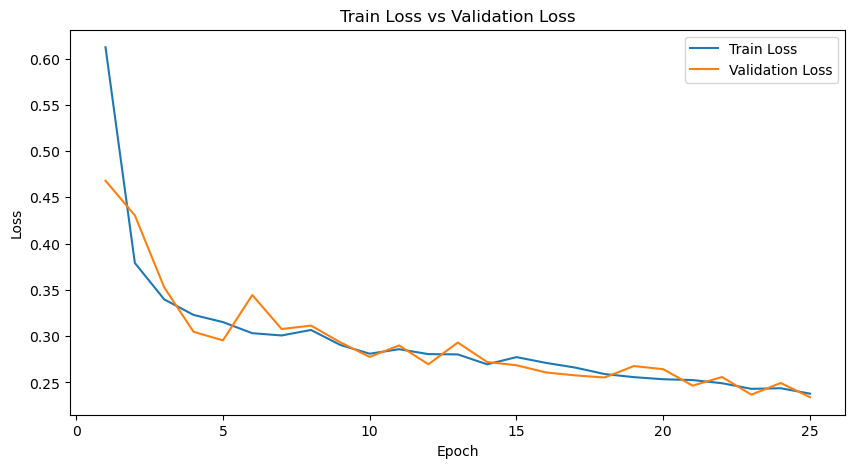

In [10]:
plot_losses(epochs_used, train_losses, val_losses)

In [11]:
model.eval()
test_loss = 0.0
test_loader_tqdm = tqdm(test_loader, desc="Testing")

with torch.no_grad():
    for images, targets in test_loader_tqdm:
        images = images.to(device)
        bboxes = extract_bboxes(targets)
        bboxes = torch.stack(bboxes).to(device)
        outputs = model(images)
        loss = criterion(outputs, bboxes)
        test_loss += loss.item()

        test_loader_tqdm.set_postfix({"Test Loss": test_loss / len(test_loader)})

test_loss = test_loss / len(test_loader)

print(f"Test Loss: {test_loss}")

Testing: 100%|██████████| 220/220 [00:12<00:00, 17.66it/s, Test Loss=0.234] 

Test Loss: 0.2339663911272179


In [12]:
save_images_with_bboxes(model, test_loader, device, dataset, "3_bigger_basic_ciou_output_imgs")

Images with bounding boxes have been saved to data\3_bigger_basic_ciou_output_imgs


In [13]:
checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': test_loss,
}
torch.save(checkpoint, os.path.join("checkpoints", "checkpoint_3_bigger_basic_ciou.pt"))